# 📊 Benchmark Analysis & Visualization

This notebook processes the raw result files generated by the C++ planner to evaluate the performance of **MeshA\*** against the baseline algorithms **LBA\*** and **LazyLBA\***. 

The analysis focuses on:
1.  **Runtime Efficiency:** Comparing the search time across different heuristic weights ($w$).
2.  **Search Space Reduction:** Analyzing the number of checked cells (nodes expanded).
3.  **Solution Quality:** Evaluating the suboptimality of the paths found relative to the optimal solution (LBA\*, $w=1$).

### Pipeline Overview
1.  **Data Ingestion:** Parse `.txt` log files from the `../../res` directory.
2.  **Filtration:** Isolate experiments based on specific **Mesh** and **Control Set** configurations.
3.  **Aggregation:** specific metrics (Time, Cost, Cells) are extracted and structured into a Pandas DataFrame.
4.  **Visualization:** Generate publication-quality plots and LaTeX-compatible tables for the AAAI submission.

In [16]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from matplotlib.patches import Rectangle


# === VISUALIZATION STYLE ===
# Ensure consistent font rendering for publication figures.
# Attempt to use Arial (standard for academic papers), fall back to sans-serif if unavailable (Linux).
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans', 'sans-serif']
# For Windows:
# plt.rcParams['font.family'] = 'Arial'


# === EXPERIMENT CONFIGURATION ===
# Define the directory and specific experiment parameters to filter files.
RESULTS_DIR = "../../res" 

# These identifiers act as anchors to parse filenames correctly.
# Only files matching these specific configurations will be processed.
MESH_NAME = "base_mesh_info"
CS_NAME = "base_control_set"

# target maps for visualization
TARGET_MAPS = ["ht_0_hightown", "AR0304SR", "Labyrinth", "Moscow_0_512"]

### 1. Data Loader & Parser

The following function scans the results directory. To ensure data integrity, it strictly filters files based on the defined `MESH_NAME` and `CS_NAME`.

**Filename Parsing Strategy:**
The filenames follow the structure: `{Map}_{Mesh}_{CS}_w{Weight}_R{R}_A{A}.txt`.
To robustly extract the variable `{Map}` name (which may contain underscores), we use the string `_{Mesh}_{CS}_w` as a fixed **anchor**. Everything to the left of the anchor is treated as the Map ID.

> **Note:** Files starting with `nb_` (notebook playground runs) or `result_` are automatically excluded to prevent dataset pollution.

In [17]:
def parse_results(directory, mesh_name, cs_name):
    """
    Parses benchmark log files and returns a structured DataFrame.
    Filters files based on the provided mesh and control set names.
    """
    data = []
    
    # Construct the strict anchor string based on the known configuration.
    # This separates the Map Name from the parameters.
    anchor = f"_{mesh_name}_{cs_name}_w"
    
    # Regex to parse the tail parameters: w, R, and A
    # Example tail: "1.1_R0_A0.txt"
    tail_pattern = re.compile(r"^([\d\.]+)_R([\d\.]+)_A(\d+)\.txt$")

    # Regex patterns for extracting metrics within the file content
    algo_header_pattern = re.compile(r"Algorithm:\s*(.+)")
    # Captures: 1=Solved (0/1), 2=Steps, 3=Cost
    res_pattern = re.compile(r"result \(solved, steps, cost\): (\d) (\d+) ([\d\.\-]+)")
    time_pattern = re.compile(r"time in working: ([\d\.]+)")
    cells_pattern = re.compile(r"number of checked cells: (\d+)")
    metrics_pattern = re.compile(r"metrics \(length, AOL\): ([\d\.]+) ([\d\.e\-\+]+)")

    files = [f for f in os.listdir(directory) if f.endswith(".txt")]
    print(f"Directory scan: found {len(files)} files. Filtering by anchor: '{anchor}'...")

    parsed_count = 0
    
    for filename in files:
        # Ignore temporary or notebook-generated files
        if filename.startswith("nb_") or filename.startswith("result_"):
            continue

        # 1. Validation: Check if file matches our Mesh/CS configuration
        if anchor not in filename:
            continue
            
        # 2. Extraction: Split filename to extract Map Name
        parts = filename.split(anchor)
        
        if len(parts) != 2:
            # print(f"Skipping malformed file: {filename}")
            continue
            
        map_name = parts[0]  # Everything before the anchor
        tail = parts[1]      # Everything after (parameters)
        
        # 3. Parameters: Parse w, R, A from the tail
        tail_match = tail_pattern.match(tail)
        if not tail_match:
            print(f"Warning: Invalid tail format in file: {filename}")
            continue
            
        w_str, r_str, a_str = tail_match.groups()
        w = float(w_str)
        
        # 4. Content Parsing: Read file and extract metrics per test
        try:
            with open(os.path.join(directory, filename), 'r', encoding='utf-8') as f:
                content = f.read()
        except Exception as e:
            print(f"Error reading {filename}: {e}")
            continue
            
        tests = content.split("=== Test")
        
        for test_chunk in tests[1:]: # Skip preamble
            id_match = re.match(r"\s*(\d+)", test_chunk)
            if not id_match: continue
            test_id = int(id_match.group(1))
            
            # Each test contains results for multiple algorithms separated by "---"
            algo_sections = test_chunk.split("---")
            
            for section in algo_sections:
                algo_match = algo_header_pattern.search(section)
                if not algo_match: continue
                
                algo_name = algo_match.group(1).strip()
                res_m = res_pattern.search(section)
                time_m = time_pattern.search(section)
                cells_m = cells_pattern.search(section)
                met_m = metrics_pattern.search(section)
                
                if res_m and time_m and cells_m and met_m:
                    data.append({
                        "Map": map_name,
                        "Weight": w,
                        "TestID": test_id,
                        "Algorithm": algo_name,
                        "Solved": int(res_m.group(1)),
                        "Cost": float(res_m.group(3)), # Crucial for suboptimality analysis
                        "Time": float(time_m.group(1)),
                        "Length": float(met_m.group(1)),
                        "CheckedCells": int(cells_m.group(1)),
                        "AOL": float(met_m.group(2))
                    })
                    parsed_count += 1

    df = pd.DataFrame(data)
    print(f"Successfully processed {parsed_count} entries.")
    
    if not df.empty:
        print(f"Unique Maps Identified: {df['Map'].unique()}")
    else:
        print("Warning: No matching data found!")
        
    return df

# Execute Loader
df_raw = parse_results(RESULTS_DIR, MESH_NAME, CS_NAME)
# Display first few rows to verify structure
df_raw.head()

Directory scan: found 49 files. Filtering by anchor: '_base_mesh_info_base_control_set_w'...
Successfully processed 532180 entries.
Unique Maps Identified: ['AR0304SR' 'AR0307SR' 'ht_0_hightown' 'Labyrinth' 'Moscow_0_512']


,Map,Weight,TestID,Algorithm,Solved,Cost,Time,Length,CheckedCells,AOL
0,AR0304SR,1.1,0,MeshA*,1,22.7555,0.005559,22.7555,2653,0.275400
1,AR0304SR,1.1,0,LBA*,1,22.7555,0.007283,22.7555,107436,0.275400
2,AR0304SR,1.1,0,LazyLBA*,1,22.7555,0.011887,22.7555,2561,0.275400
3,AR0304SR,1.1,1,MeshA*,1,23.8681,0.012847,23.8681,3461,0.276048
4,AR0304SR,1.1,1,LBA*,1,23.8681,0.014745,23.8681,114560,0.276048


### 2. Data Pivoting & Preprocessing

Here we transform the "long" dataframe into a "wide" format. 
Each row represents a single test instance (unique combination of Map, Weight, and TestID). 
The columns contain metrics for each algorithm.

This structure allows us to calculate relative metrics easily, e.g.:
$$\text{RelTime}_{MeshA*} = \frac{\text{Time}_{MeshA*}}{\text{Time}_{LBA*}} \times 100 \%$$

In [18]:
if not df_raw.empty:
    # 1. Pivot Table
    df_pivot = df_raw.pivot_table(
        index=["Map", "Weight", "TestID"], 
        columns="Algorithm", 
        values=["Time", "Solved", "Cost", "CheckedCells", "Length"],
        aggfunc='first'
    ).reset_index()
    
    # Flatten MultiIndex columns (e.g., ('Time', 'MeshA*') -> 'Time_MeshA*')
    df_pivot.columns = [f"{c[0]}_{c[1]}" if c[1] else c[0] for c in df_pivot.columns]
    
    # 2. Add OPTIMAL Cost reference (LBA* at w=1)
    # We look up the cost found by LBA* at w=1 for each specific test ID
    opt_costs = df_raw[(df_raw["Algorithm"] == "LBA*") & (df_raw["Weight"] == 1.0)][["Map", "TestID", "Cost"]]
    opt_costs = opt_costs.rename(columns={"Cost": "Optimal_Cost"})
    
    df_pivot = pd.merge(df_pivot, opt_costs, on=["Map", "TestID"], how="left")
    
    # 3. Calculate RATIOS (Row-by-Row)
    # This ensures consistency between plots and tables.
    
    # --- A. Cost Suboptimality (vs Optimal Cost) ---
    for algo in ["MeshA*", "LBA*", "LazyLBA*"]:
        if f"Cost_{algo}" in df_pivot.columns:
            # Calculate % of optimal cost (100% = optimal)
            df_pivot[f"Subopt_{algo}"] = (df_pivot[f"Cost_{algo}"] / df_pivot["Optimal_Cost"]) * 100

    # --- B. Runtime Ratio (vs LBA* at current w) ---
    baseline = "LBA*"
    for algo in ["MeshA*", "LazyLBA*"]:
        if f"Time_{algo}" in df_pivot.columns and f"Time_{baseline}" in df_pivot.columns:
            # Calculate % of baseline time ( < 100% means faster)
            df_pivot[f"RelTime_{algo}"] = (df_pivot[f"Time_{algo}"] / df_pivot[f"Time_{baseline}"]) * 100

    # --- C. Cells Ratio (vs LazyLBA* at current w) ---
    # Specifically for the Checked Cells bar chart
    lazy_base = "LazyLBA*"
    for algo in ["MeshA*"]: 
        if f"CheckedCells_{algo}" in df_pivot.columns and f"CheckedCells_{lazy_base}" in df_pivot.columns:
             df_pivot[f"RelCells_{algo}_vs_Lazy"] = (df_pivot[f"CheckedCells_{algo}"] / df_pivot[f"CheckedCells_{lazy_base}"]) * 100

    print(f"Metrics calculated. Total pivot records: {len(df_pivot)}")
else:
    print("DataFrame is empty!")

Metrics calculated. Total pivot records: 177394


### 3. Detailed Per-Map Statistics

The following function provides a granular performance analysis for each map at a specific weight $w$.

**Methodology for Speed Comparison:**
To ensure statistical robustness, we calculate the speed factor **instance-by-instance**, rather than comparing aggregated averages. This prevents long-running tests from skewing the results.

The process is as follows:
1.  **Intersection:** Identify the subset of tests $\mathcal{T}$ solved by both the Target Algorithm and the Baseline ($LBA^*$).
2.  **Instance Ratio:** For each test instance $i \in \mathcal{T}$, calculate the ratio:
    $$r_i = \frac{\text{Time}_{\text{Target}}^{(i)}}{\text{Time}_{\text{Baseline}}^{(i)}}$$
3.  **Aggregation:** Report the **Median** of these ratios ($\tilde{r}$).

**Interpretation:**
* $\text{Factor} < 1.0$: The target algorithm is **faster** (e.g., $0.6$ means it takes $60\%$ of the baseline time).
* $\text{Factor} > 1.0$: The target algorithm is **slower**.

> **Note:** The `Success Rate` is strictly relative to the Baseline. If $LBA^*$ solves 100 tests and $MeshA^*$ solves 95 of those specific tests, the success rate is $95\%$.\
> **Note:** Since all tested algorithms (MeshA*, LBA*, LazyLBA*) are theoretically optimal, they are expected to yield a **100% success rate** relative to each other on solvable instances. Consequently, the set of test instances solved by each algorithm must be identical.

In [19]:
def print_detailed_stats(df_pivot, w_list):
    maps = df_pivot["Map"].unique()
    baseline_algo = "LBA*"
    
    for w in w_list:
        print(f"\n{'='*60}")
        print(f"=== ANALYSIS FOR WEIGHT w={w} ===")
        print(f"{'='*60}")
        
        for map_name in maps:
            subset = df_pivot[(df_pivot["Map"] == map_name) & (df_pivot["Weight"] == w)].copy()
            if subset.empty: continue
                
            # --- Validation Logic ---
            if f"Solved_{baseline_algo}" not in subset.columns: continue
            
            # Ground truth: tests solved by LBA*
            valid_mask = subset[f"Solved_{baseline_algo}"] == 1
            solved_by_base = valid_mask.sum()
            
            if solved_by_base == 0: continue

            print(f"Map: {map_name:<20} | Total tests: {len(subset)}")
            
            summary_rows = []
            target_algos = ["MeshA*", "LBA*", "LazyLBA*"] 
            
            # Use strictly the intersection of solved tests
            data_valid = subset[valid_mask] 
            
            for algo in target_algos:
                if f"Solved_{algo}" not in subset.columns: continue
                
                # 1. Intersection: Solved by BOTH Base AND Target
                also_solved_mask = data_valid[f"Solved_{algo}"] == 1
                also_solved_count = also_solved_mask.sum()
                
                # 2. Metrics on Common Set
                data_common = data_valid[also_solved_mask]
                
                if not data_common.empty:
                    # Absolute Time (Median of raw times in ms)
                    time_med = data_common[f"Time_{algo}"].median() * 1000
                    
                    # Relative Time (%) - EXACTLY matching the graph logic
                    # We use the 'RelTime' column calculated row-by-row in Preprocessing
                    # Logic: (Time_Algo / Time_Base) * 100
                    if algo == baseline_algo:
                        rel_time_med = 100.0
                    elif f"RelTime_{algo}" in data_common.columns:
                        rel_time_med = data_common[f"RelTime_{algo}"].median()
                    else:
                        rel_time_med = np.nan
                        
                    success_rate = (also_solved_count / solved_by_base) * 100
                else:
                    time_med = rel_time_med = 0
                    success_rate = 0

                summary_rows.append({
                    "Algorithm": algo,
                    "Solved (Subset)": also_solved_count,
                    "Success Rate": f"{success_rate:.1f}%",
                    "Time Med (ms)": f"{time_med:.2f}",
                    "Med. Rel. Time": f"{rel_time_med:.1f}%" # Shows 60% instead of 0.6x
                })
                
            display(pd.DataFrame(summary_rows))

# Run the detailed analysis
print_detailed_stats(df_pivot, [1])


=== ANALYSIS FOR WEIGHT w=1 ===
Map: AR0304SR             | Total tests: 4020


,Algorithm,Solved (Subset),Success Rate,Time Med (ms),Med. Rel. Time
0,MeshA*,3510,100.0%,585.96,62.9%
1,LBA*,3510,100.0%,904.89,100.0%
2,LazyLBA*,3510,100.0%,1104.69,120.3%


Map: AR0307SR             | Total tests: 10140


,Algorithm,Solved (Subset),Success Rate,Time Med (ms),Med. Rel. Time
0,MeshA*,6999,100.0%,1157.09,108.8%
1,LBA*,6999,100.0%,1156.88,100.0%
2,LazyLBA*,6999,100.0%,2520.81,218.4%


Map: Labyrinth            | Total tests: 10144


,Algorithm,Solved (Subset),Success Rate,Time Med (ms),Med. Rel. Time
0,MeshA*,9157,100.0%,3706.21,68.9%
1,LBA*,9157,100.0%,5540.28,100.0%
2,LazyLBA*,9157,100.0%,6901.06,116.9%


Map: Moscow_0_512         | Total tests: 5490


,Algorithm,Solved (Subset),Success Rate,Time Med (ms),Med. Rel. Time
0,MeshA*,4753,100.0%,1272.98,63.2%
1,LBA*,4753,100.0%,1985.89,100.0%
2,LazyLBA*,4753,100.0%,2136.40,107.6%


Map: ht_0_hightown        | Total tests: 4200


,Algorithm,Solved (Subset),Success Rate,Time Med (ms),Med. Rel. Time
0,MeshA*,3100,100.0%,519.72,82.6%
1,LBA*,3100,100.0%,625.08,100.0%
2,LazyLBA*,3100,100.0%,1086.61,172.0%


### 4. Aggregated Cost Table (Suboptimality)

This section generates the **Suboptimality Table** (Cost Analysis). It measures the quality of the paths found relative to the optimal solution.

**Methodology:**
Similar to the runtime analysis, we compute the relative cost **instance-by-instance** before aggregating:

1.  **Reference:** Let $C^*_{i}$ be the cost of the optimal path for test $i$ (found by $LBA^*$ with $w=1$).
2.  **Relative Cost:** For algorithm $A$ on test $i$, calculate:
    $$\text{Subopt}_{i} = \frac{\text{Cost}_A^{(i)}}{C^*_{i}} \times 100$$
3.  **Aggregation:** The table reports the **Median** of these values for each map/weight configuration.

**Interpretation:**
* **100.0:** The algorithm finds the optimal path (median case).
* **> 100.0:** The algorithm finds a sub-optimal path. For example, `105.4` implies a $5.4\%$ cost overhead compared to the optimal.

In [20]:
def generate_full_cost_table(df, maps, weights):
    # Rows: Algorithms
    # Cols: Map -> w
    algos = ["LBA*", "LazyLBA*", "MeshA*"]
    
    cols = pd.MultiIndex.from_product([maps, weights], names=["Map", "w"])
    res_df = pd.DataFrame(index=algos, columns=cols)
    
    for algo in algos:
        for map_name in maps:
            for w in weights:
                # Filter: Map, Weight, Solved, and Optimal Cost exists
                subset = df[
                    (df["Map"] == map_name) & 
                    (df["Weight"] == w) & 
                    (df[f"Solved_{algo}"] == 1) & 
                    (df["Optimal_Cost"] > 0)
                ]
                
                if not subset.empty:
                    # Use pre-calculated Subopt metric
                    val = subset[f"Subopt_{algo}"].median()
                    res_df.loc[algo, (map_name, w)] = f"{val:.1f}"
                else:
                    res_df.loc[algo, (map_name, w)] = "-"

    return res_df

print("=== Full Cost Table (Median % of Optimal Cost) ===")
cost_table = generate_full_cost_table(df_pivot, TARGET_MAPS, [1.0, 2.0, 5.0, 10.0])

display(HTML(cost_table.to_html()))
# print(cost_table.to_latex())

=== Full Cost Table (Median % of Optimal Cost) ===


### 5. Visualization: Runtime vs Heuristic Weight

This plot compares the relative runtime of algorithms as the heuristic weight ($w$) increases.

* **Metric:** Median Relative Time relative to $LBA*$ (Baseline).
* **Y-Axis:** Percentage ($< 100\%$ means faster than Baseline).
* **X-Axis:** Heuristic Weight $w \in \{1, 1.1, 2, 5, 10\}$.
* **Reference Lines:**
    * **x1.5:** Speedup factor of 1.5 ($66.6\%$).
    * **x2:** Speedup factor of 2.0 ($50\%$).

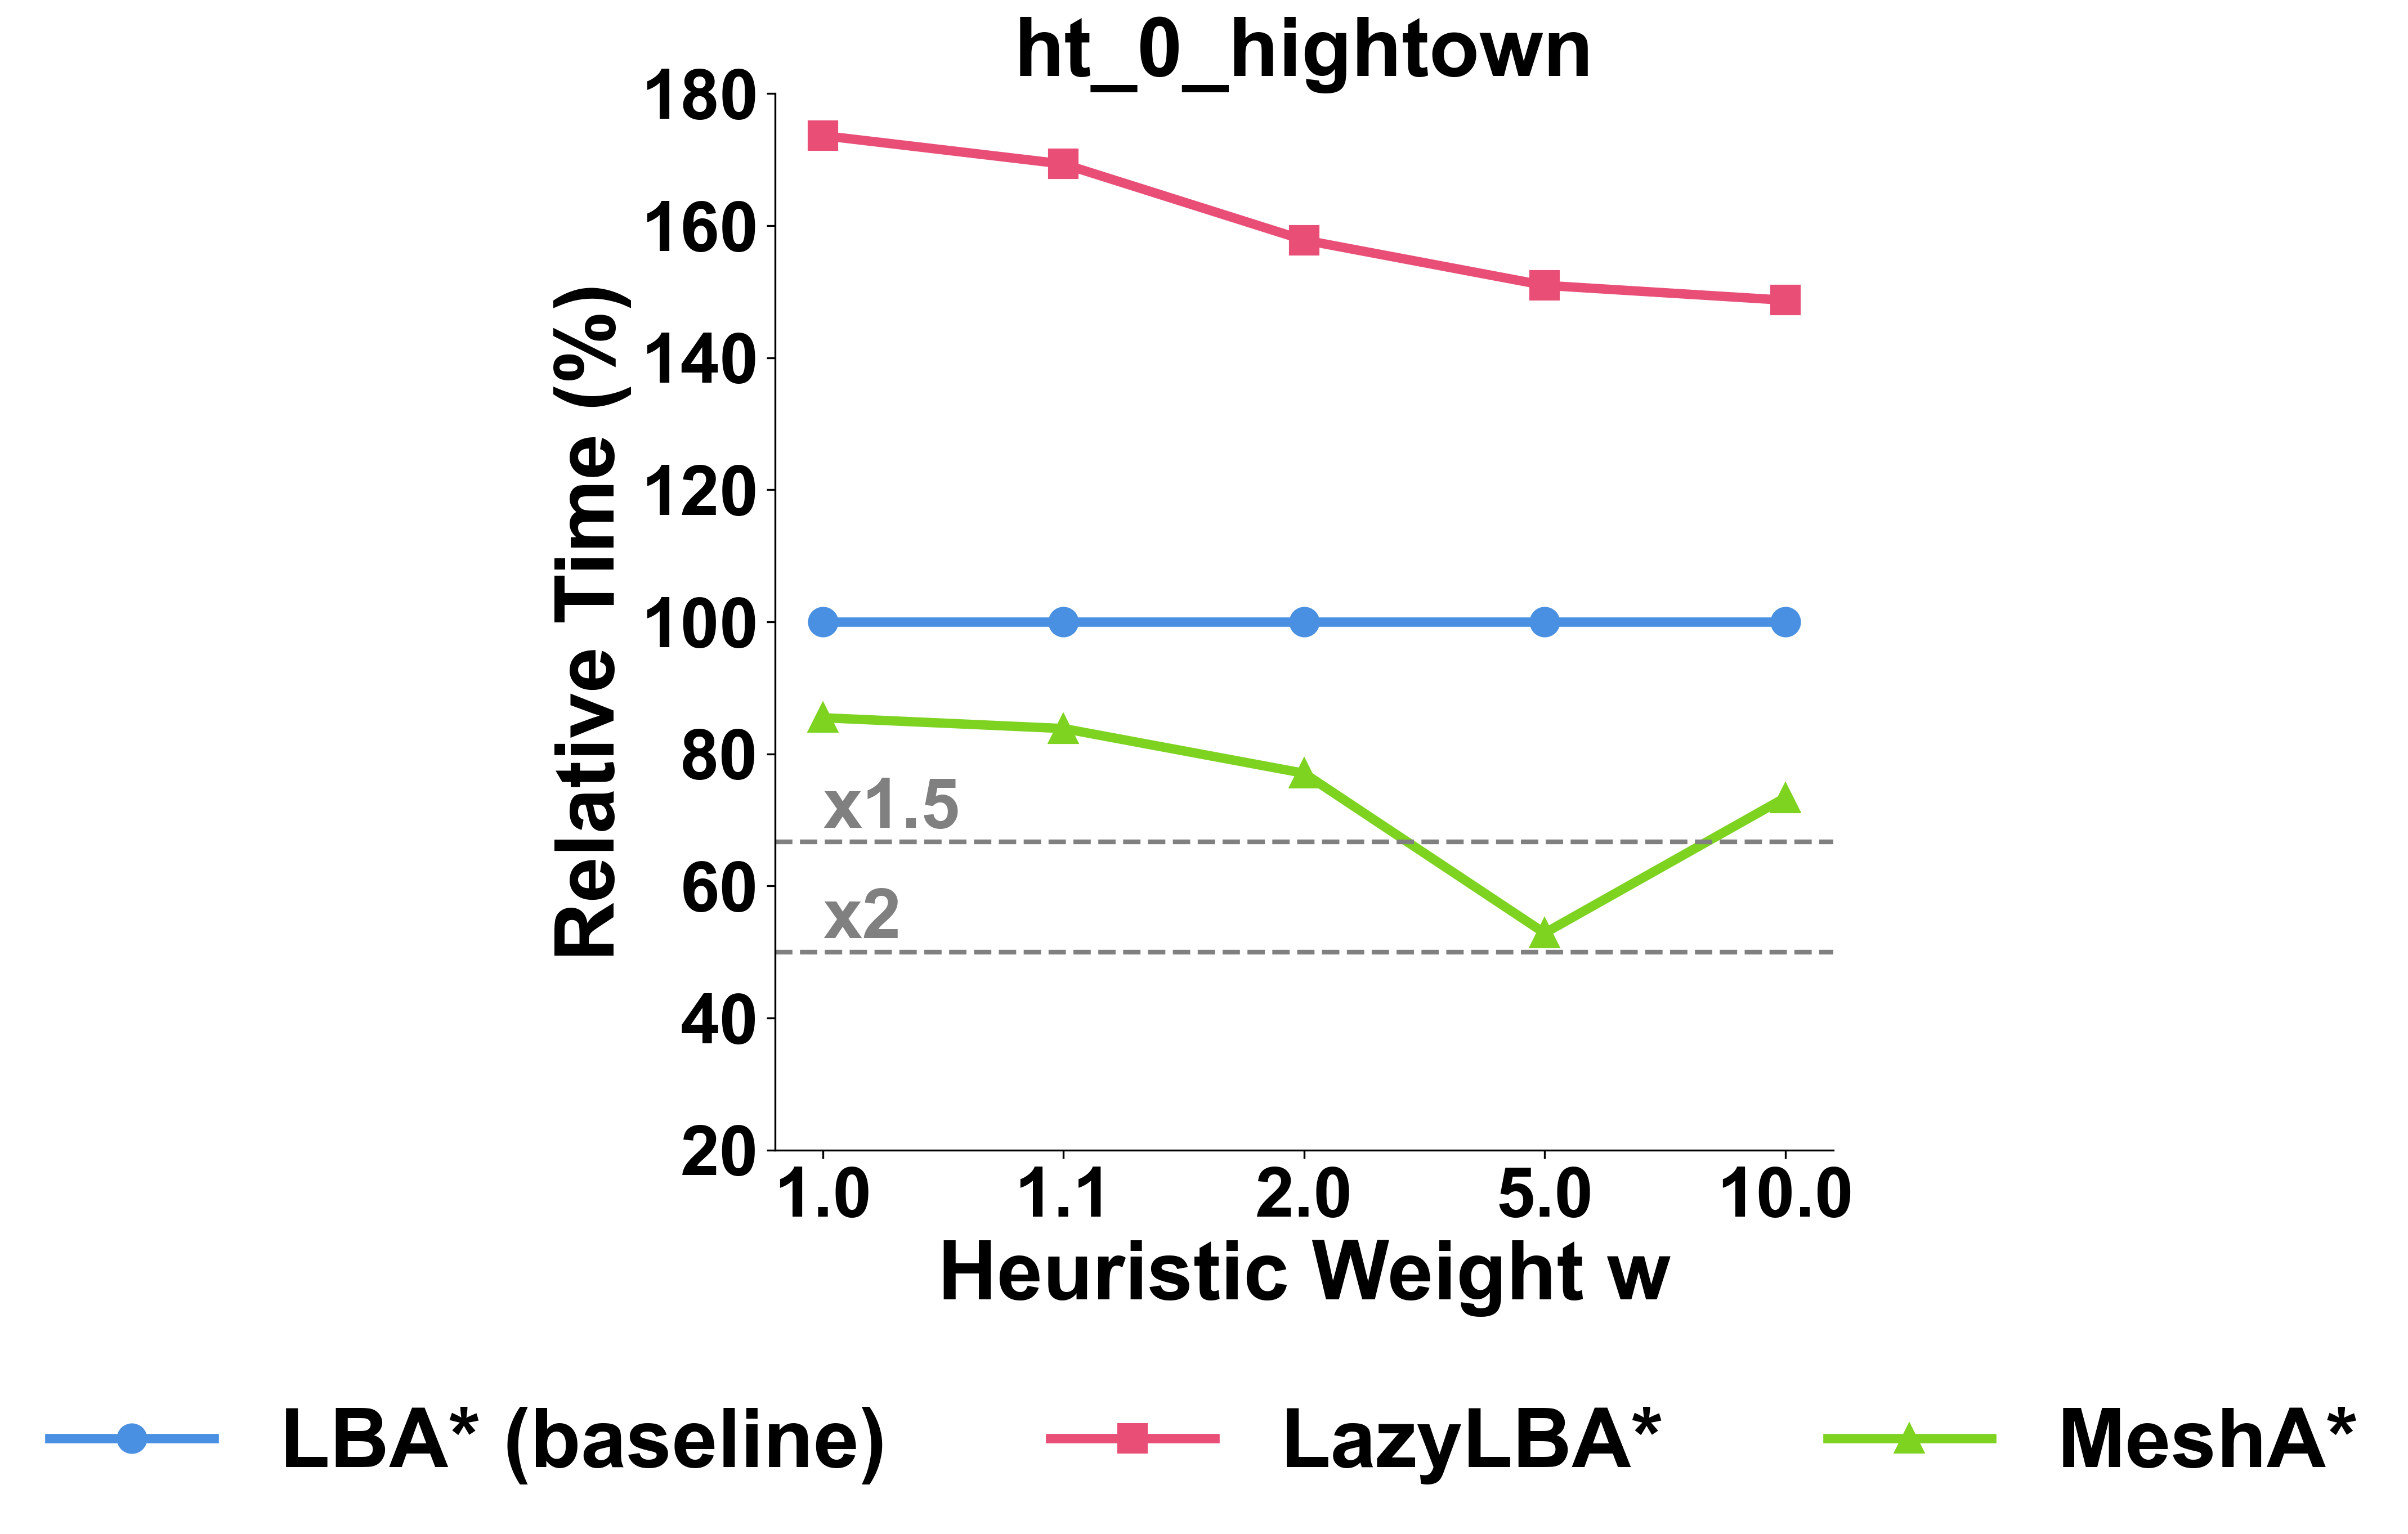

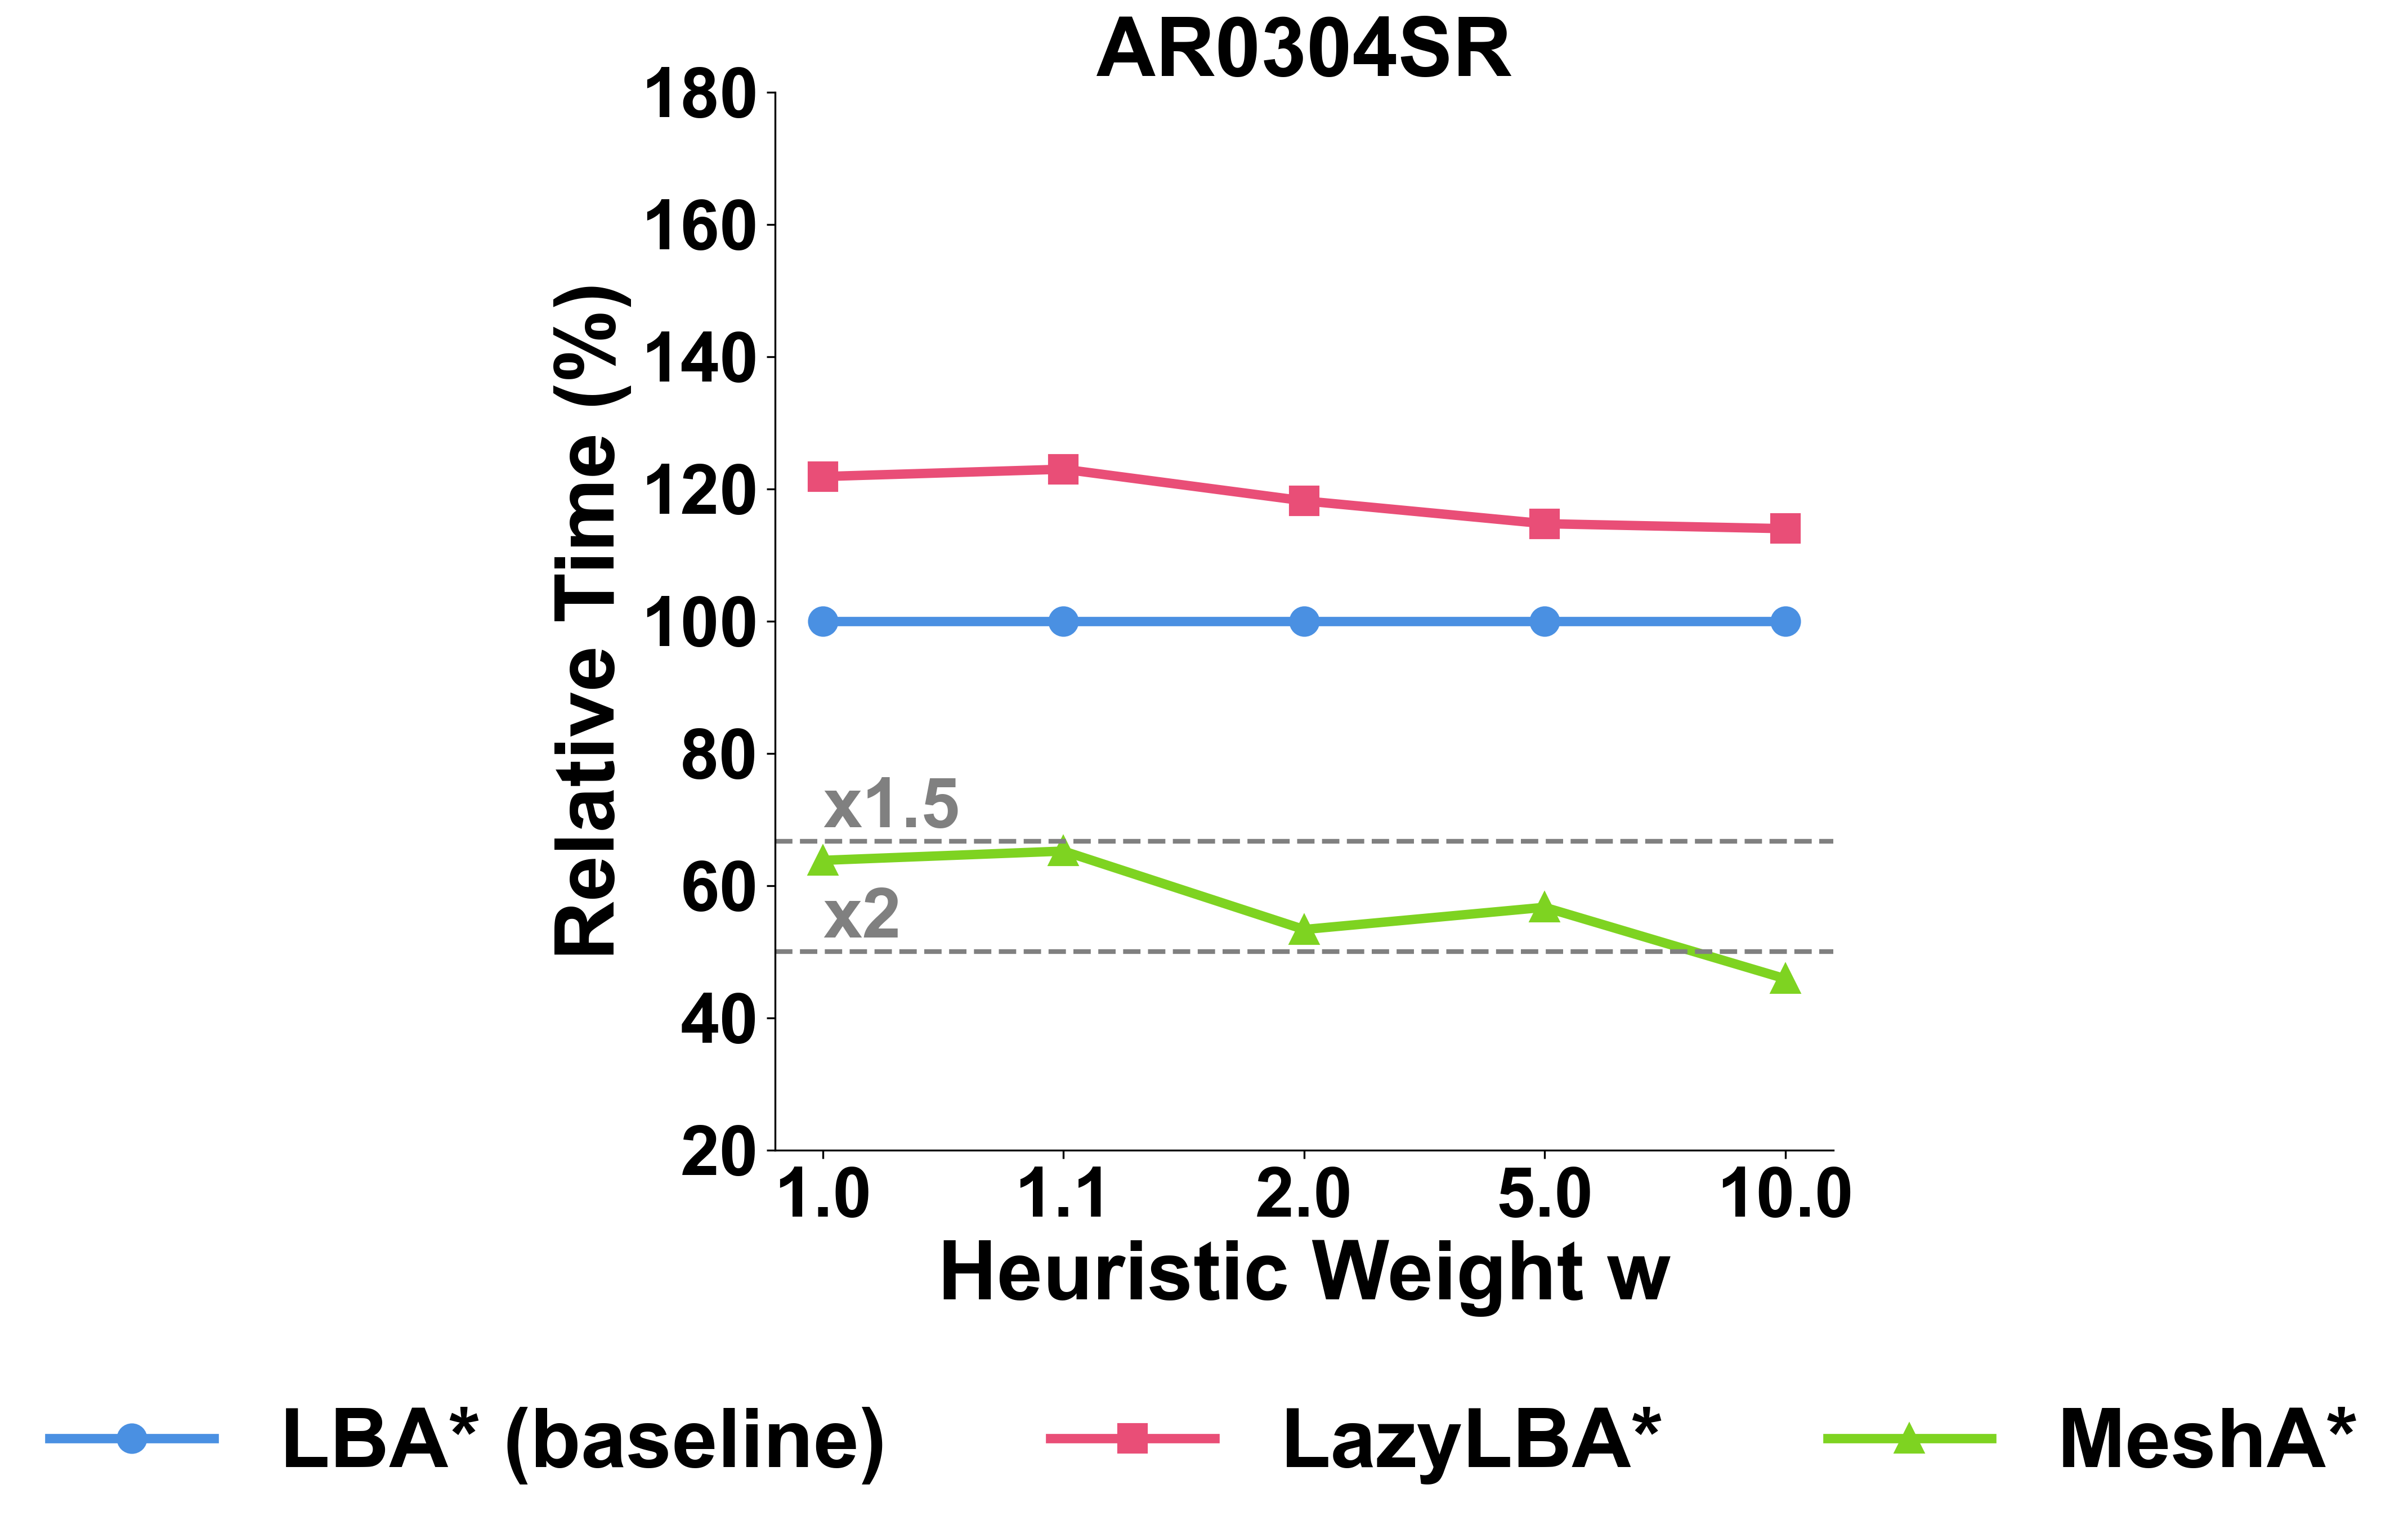

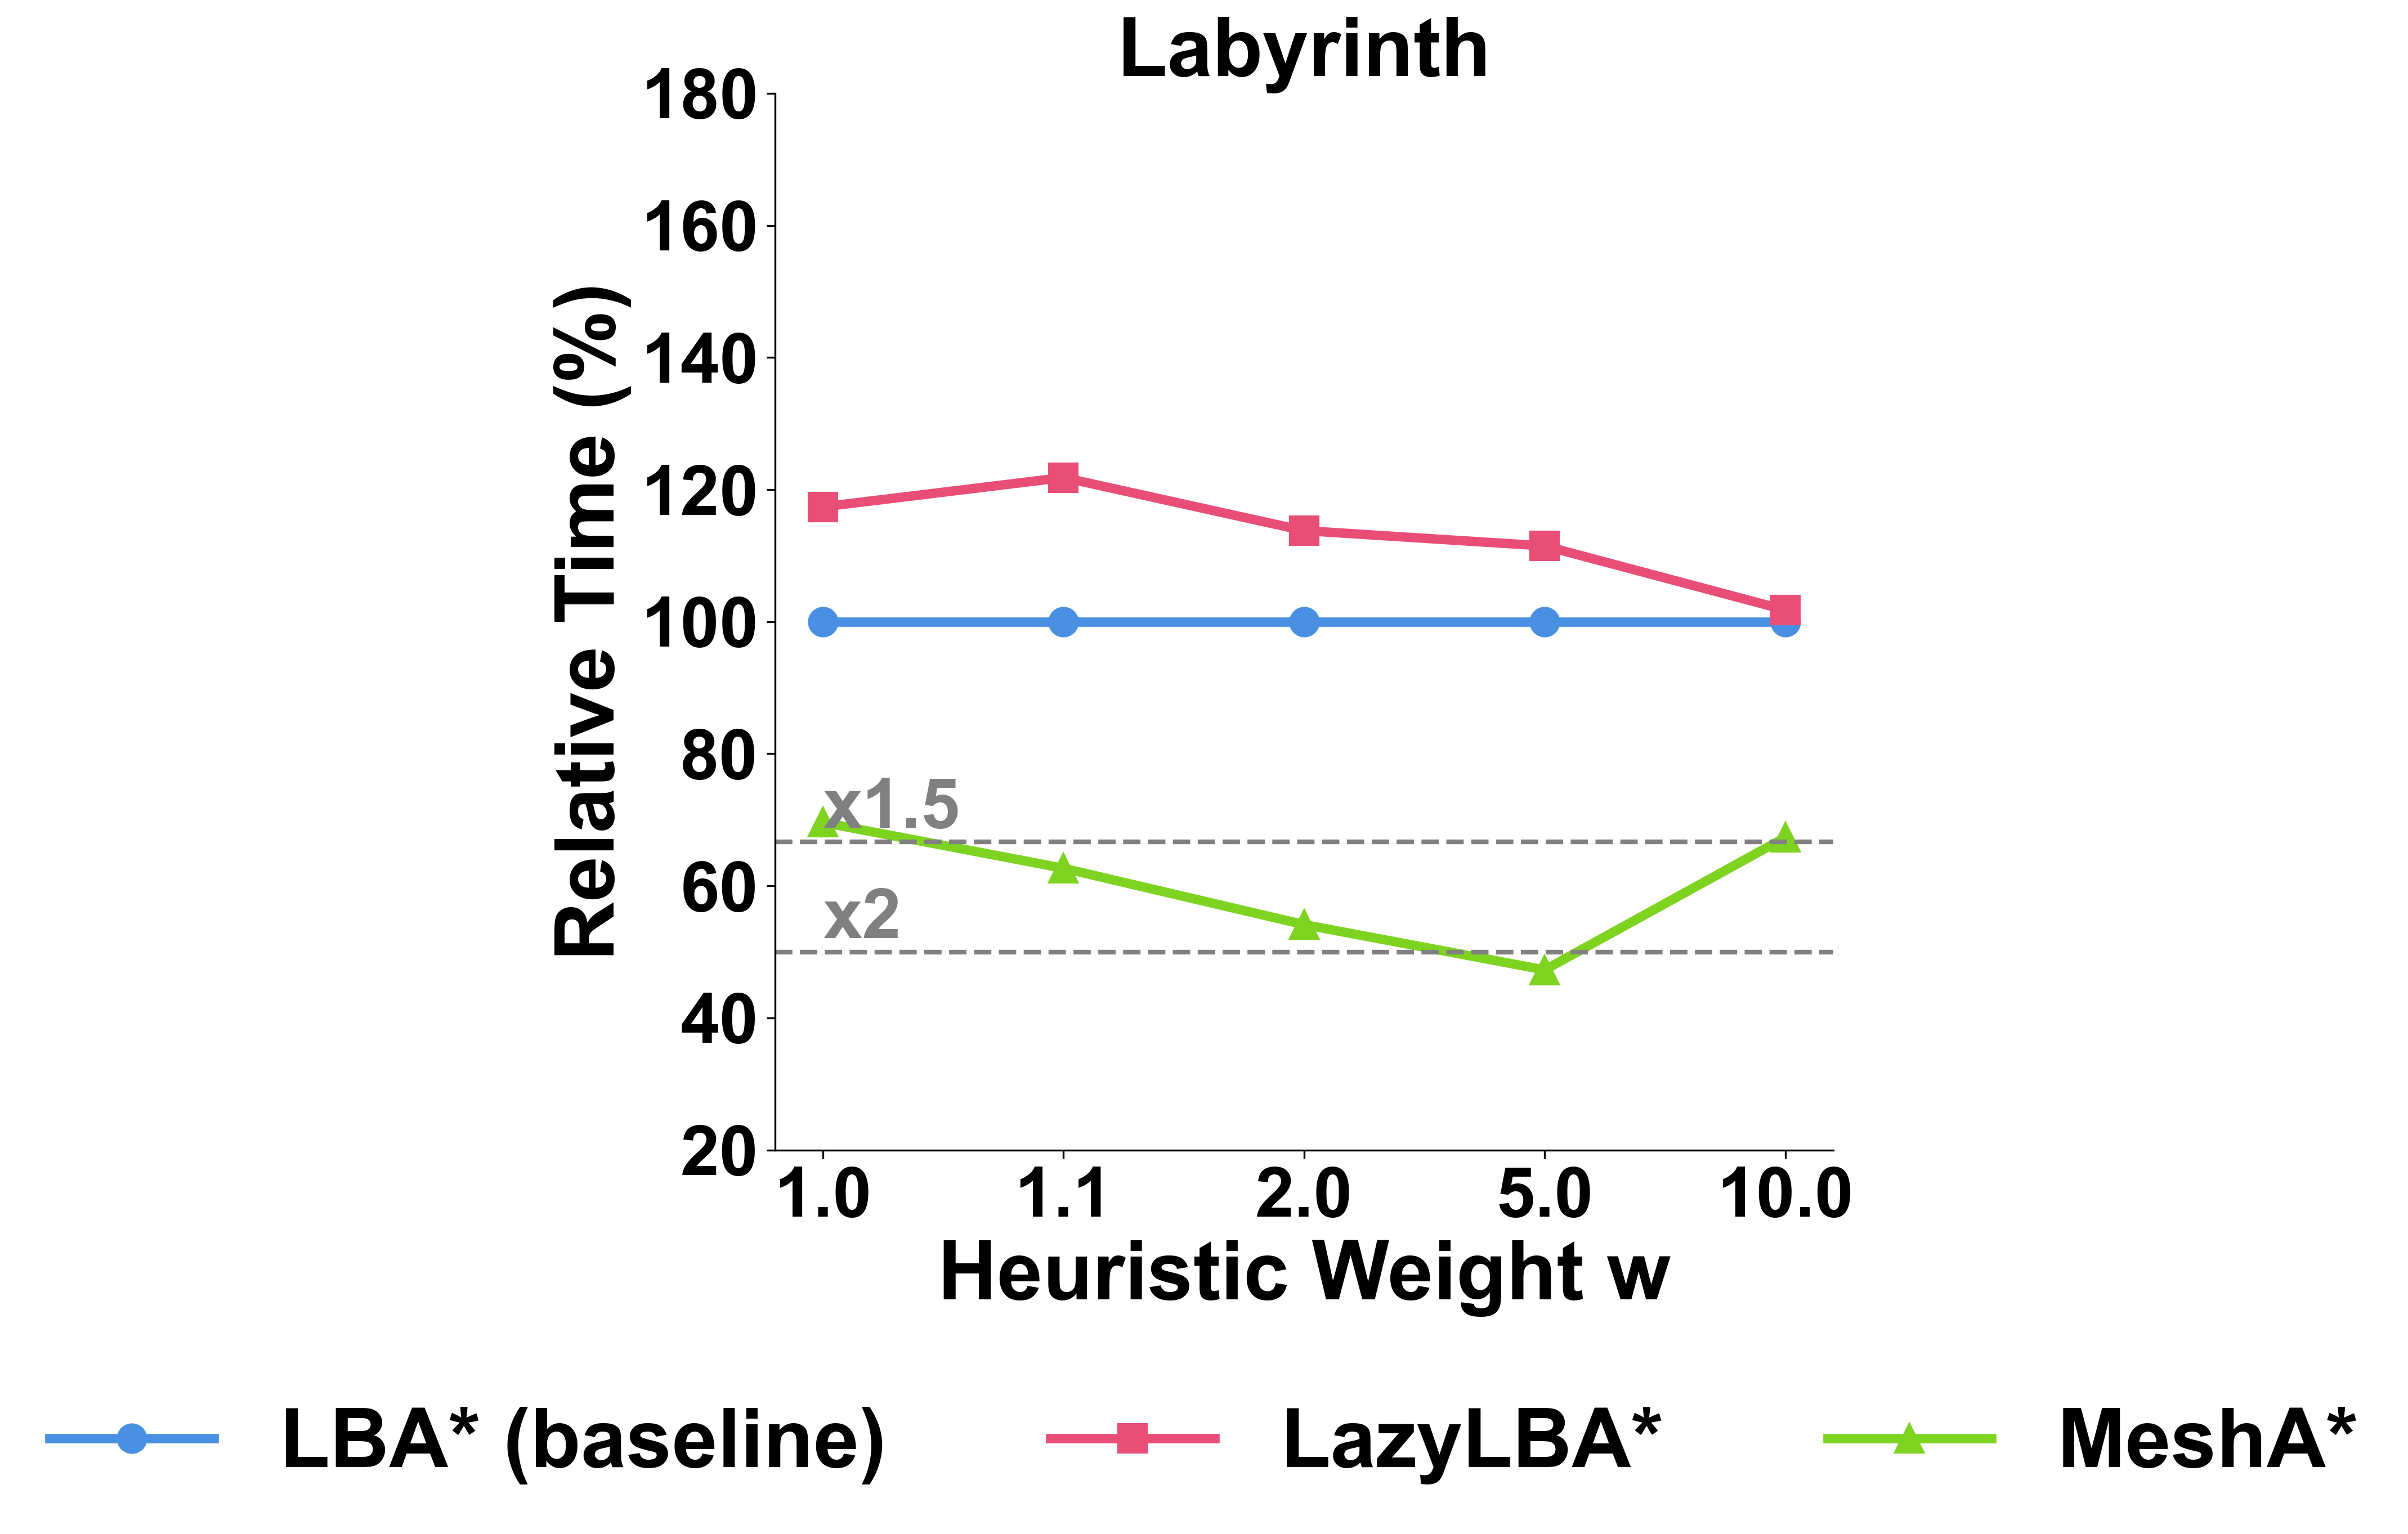

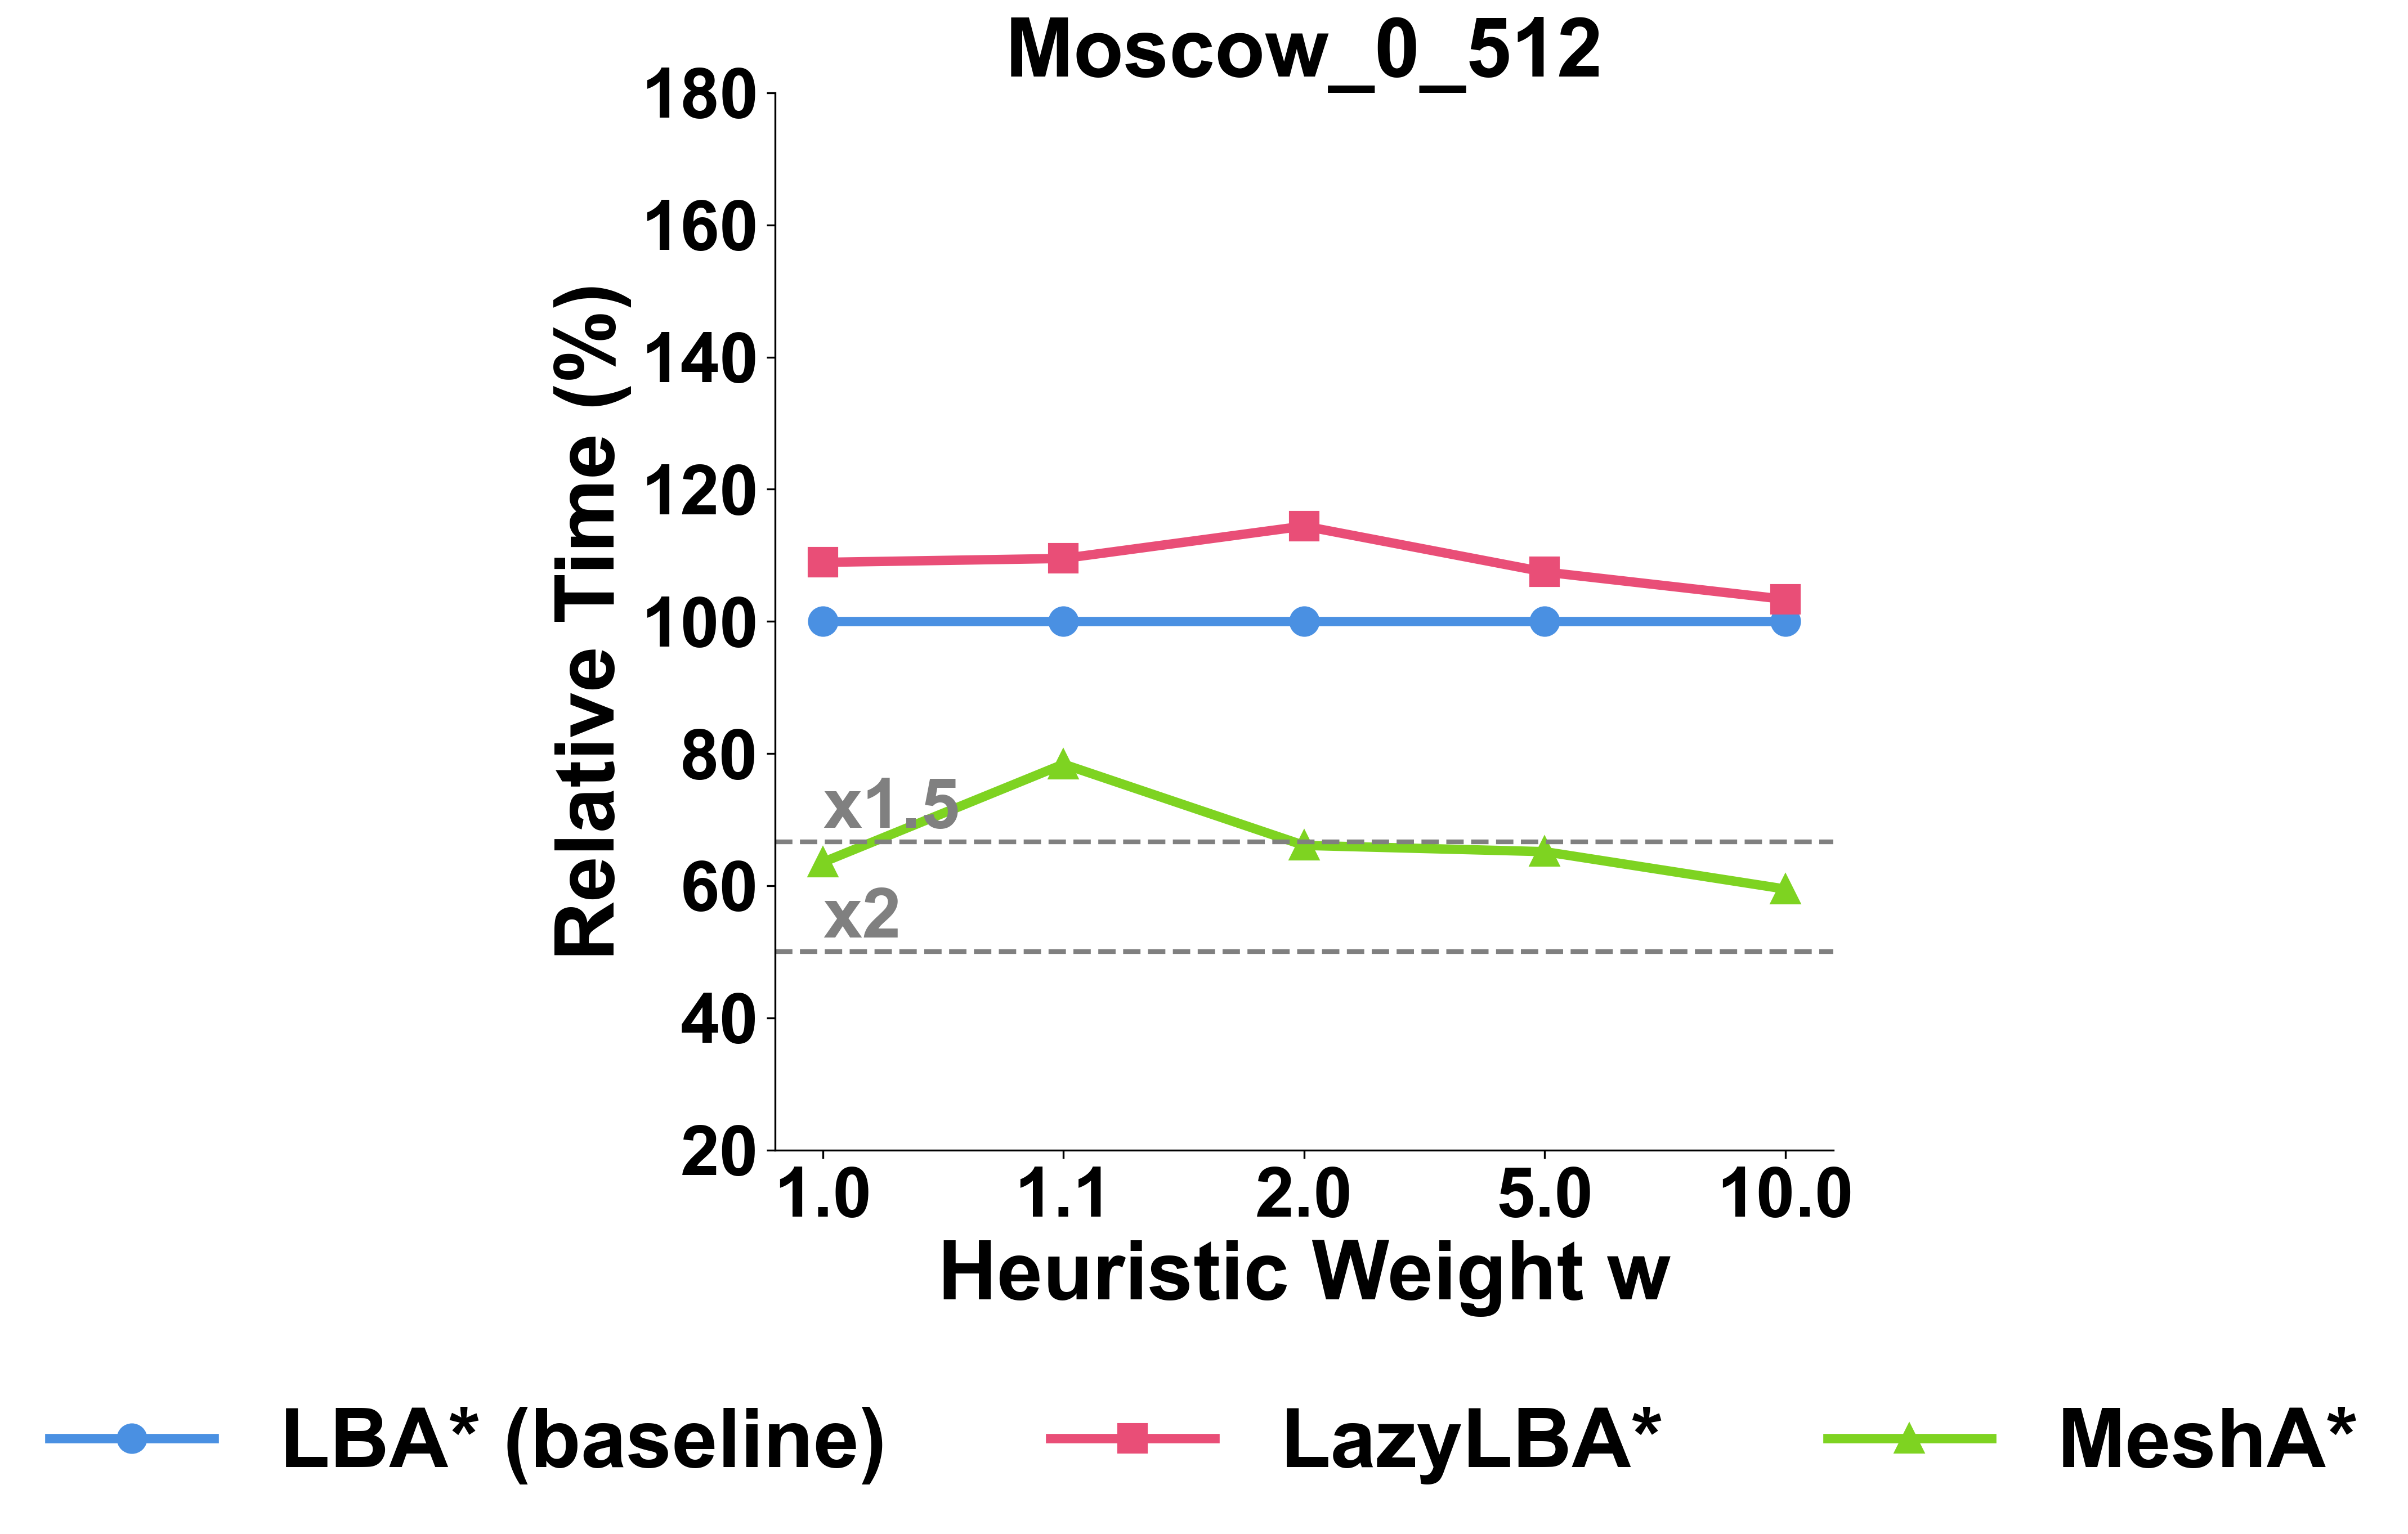

In [21]:
def plot_runtime_comparison(df, maps_list):
    # Data Configuration
    w_values = [1.0, 1.1, 2.0, 5.0, 10.0]
    
    # Style Configuration (Strictly matching reference)
    colors = {
        'LBA*': '#4A90E2',      # Blue
        'LazyLBA*': '#E94E77',  # Pinkish/Red
        'MeshA*': '#7ED321'     # Green
    }
    markers = {'LBA*': 'o', 'LazyLBA*': 's', 'MeshA*': '^'}
    line_width = 4
    marker_size = 12
    
    # Global Font Config for this plot
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']

    for i, task_map in enumerate(maps_list):
        fig, ax = plt.subplots(figsize=(8, 8), dpi=300)
        
        # Data Containers
        medians = {'LBA*': [], 'LazyLBA*': [], 'MeshA*': []}
        
        for w in w_values:
            # Filter specifically for this Map and Weight
            subset = df[(df["Map"] == task_map) & (df["Weight"] == w)]
            
            # --- LBA* (Baseline) ---
            # Always 100% by definition
            medians['LBA*'].append(100.0)
            
            # --- LazyLBA* & MeshA* ---
            # We use the 'RelTime' columns calculated in Preprocessing.
            # These columns already contain (Time_Algo / Time_LBA*) * 100
            if not subset.empty:
                val_lazy = subset["RelTime_LazyLBA*"].median()
                val_mesh = subset["RelTime_MeshA*"].median()
                
                medians['LazyLBA*'].append(val_lazy)
                medians['MeshA*'].append(val_mesh)
            else:
                medians['LazyLBA*'].append(np.nan)
                medians['MeshA*'].append(np.nan)
        
        # === PLOTTING ===
        # 1. LBA* Baseline
        ax.plot(range(len(w_values)), medians['LBA*'], 
                marker=markers['LBA*'], color=colors['LBA*'], 
                linewidth=line_width, markersize=marker_size, label='LBA* (baseline)')
        
        # 2. LazyLBA*
        ax.plot(range(len(w_values)), medians['LazyLBA*'], 
                marker=markers['LazyLBA*'], color=colors['LazyLBA*'], 
                linewidth=line_width, markersize=marker_size, label='LazyLBA*')
        
        # 3. MeshA*
        ax.plot(range(len(w_values)), medians['MeshA*'], 
                marker=markers['MeshA*'], color=colors['MeshA*'], 
                linewidth=line_width, markersize=marker_size, label='MeshA*')

        # === STYLING ===
        # X-Axis
        ax.set_xticks(range(len(w_values)))
        ax.set_xticklabels([str(w) for w in w_values])
        
        # Y-Axis (Strictly 20 to 200 step 20)
        ax.set_yticks(range(20, 200, 20)) 
        
        # Titles & Labels
        ax.set_title(f'{task_map}', fontsize=35, fontweight='bold')
        ax.set_xlabel('Heuristic Weight w', fontsize=35, fontweight='bold')
        ax.set_ylabel('Relative Time (%)', fontsize=35, fontweight='bold')
        
        # Ticks Styling
        ax.tick_params(axis='both', labelsize=30)
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontweight('bold')
            
        # Spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Reference Lines (Speedup Factors)
        # x1.5 = 66.6%
        ax.axhline(y=(2/3)*100, color='gray', linestyle='--', linewidth=line_width/2)
        ax.text(0, (2/3)*100, 'x1.5', color='gray', verticalalignment='bottom', fontsize=30, fontweight='bold')
        
        # x2 = 50%
        ax.axhline(y=50, color='gray', linestyle='--', linewidth=line_width/2)
        ax.text(0, 50, 'x2', color='gray', verticalalignment='bottom', fontsize=30, fontweight='bold')
        
        # Legend (Strict positioning)
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, 
                   loc='lower center', ncol=3,  # Using 3 cols for 3 items fits better, but keeps structure
                   bbox_to_anchor=(0.5, -0.16), 
                   prop={'weight': 'bold', 'size': 35}, frameon=False)
        
        plt.tight_layout()
        # plt.savefig(f"../../images/relative_time_{i}.png", transparent=False, bbox_inches="tight", facecolor='white')
        plt.show()

# Run Visualization
# Make sure to use the 'df_pivot' which contains the aggregated data
plot_runtime_comparison(df_pivot, TARGET_MAPS)

### 6. Visualization: Checked Cells Analysis

This Box-Plot demonstrates the reduction in the search space (number of checked cells) achieved by **MeshA*** compared to **LazyLBA***.

* **Metric:** $\frac{\text{Cells}_{MeshA*}}{\text{Cells}_{LazyLBA*}} \times 100 \%$
* **Interpretation:** Values $< 100\%$ indicate that MeshA* is more efficient (processes fewer nodes).
* **Grouping:** Results are grouped by Map and colored by Heuristic Weight $w$.

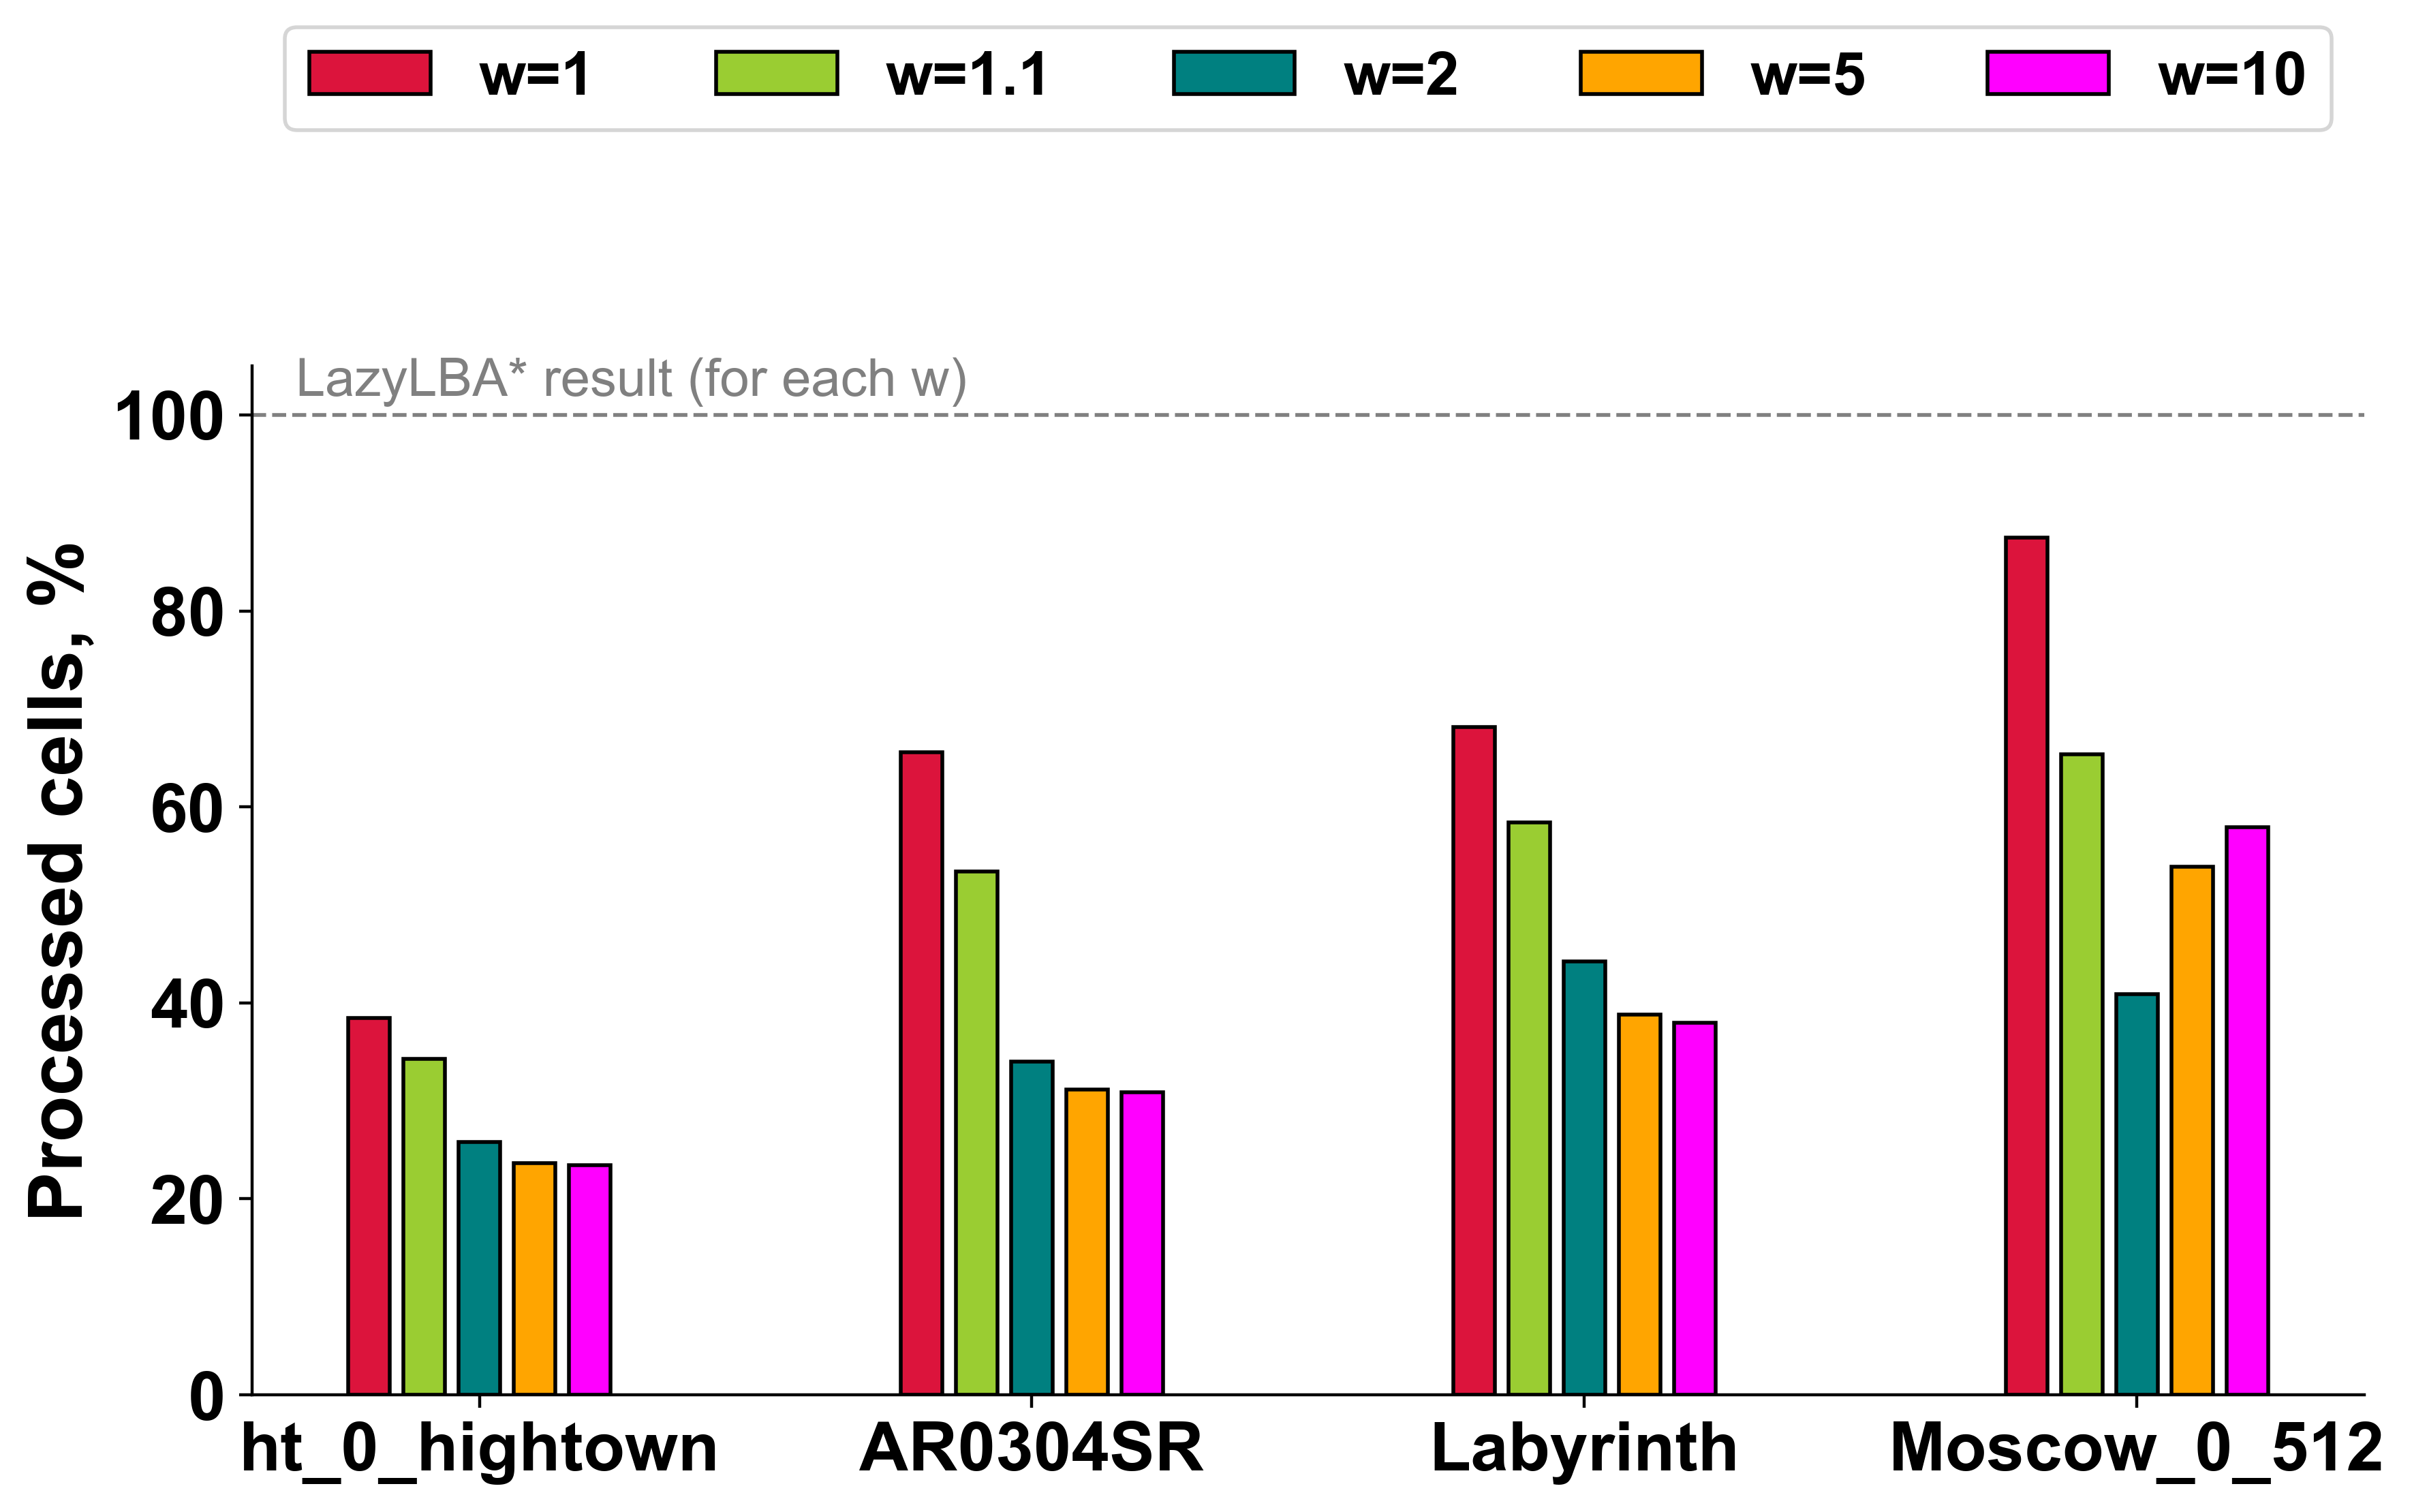

In [22]:
def plot_cells_strict_style(df, maps):
    # Data Configuration
    w_values = [1, 1.1, 2, 5, 10]
    shift = 0.4
    
    # Prepare list-of-lists structure for medians
    # medians_for_w[map_idx] -> list of medians for each w
    medians_for_w = []
    
    for i, task_map in enumerate(maps):
        medians_for_w.append([])
        for w in w_values:
            # Filter: Solved by BOTH algorithms (Strict Intersection)
            subset = df[
                (df["Map"] == task_map) & 
                (df["Weight"] == w) & 
                (df["Solved_MeshA*"] == 1) & 
                (df["Solved_LazyLBA*"] == 1)
            ]
            
            if not subset.empty and "RelCells_MeshA*_vs_Lazy" in subset.columns:
                # Take the median of the pre-calculated ratio
                val = subset["RelCells_MeshA*_vs_Lazy"].median()
                medians_for_w[i].append(val)
            else:
                medians_for_w[i].append(0)

    # === PLOTTING ===
    fig, ax = plt.subplots(figsize=(10, 5), dpi=400)
    
    # Fonts
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
    
    ax.set_ylabel("Processed cells, %", fontsize=20, fontweight='bold')

    index = 4 * np.arange(len(maps))
    colors = ["crimson", "yellowgreen", "teal", "orange", "magenta"]
    width = 0.3 

    # Draw Bars
    for w_idx in range(5):
        medians = [medians_for_w[map_idx][w_idx] for map_idx in range(len(maps))]
        ax.bar(index + w_idx * shift, medians, width=width, 
               color=colors[w_idx], edgecolor='black', linewidth=1)

    # Custom Legend
    legend_elements = [Rectangle((0, 0), 1, 1, facecolor=colors[i], edgecolor='black') 
                       for i in range(5)]
    legend_labels = ["w=1", "w=1.1", "w=2", "w=5", "w=10"]
    
    plt.legend(legend_elements, legend_labels,
               bbox_to_anchor=(0.5, 1.2), labelspacing=1.2, 
               prop={'weight': 'bold', 'size': 16}, 
               loc='lower center', ncol=5)

    # Axis Formatting
    plt.xticks(index + 2 * shift, maps)

    for label in ax.get_yticklabels():
        label.set_fontsize(18)
        label.set_fontweight('bold')
    for label in ax.get_xticklabels():
        label.set_fontsize(18)
        label.set_fontweight('bold')

    # Spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Reference Line (100%)
    ax.axhline(y=100, color='gray', linestyle='--', linewidth=1)
    ax.text(x=1.9, y=102, s="LazyLBA* result (for each w)", color='gray', fontsize=14, ha='center')

    # plt.savefig("../../images/checked_cells.png", transparent=False, bbox_inches="tight", facecolor='white')
    plt.show()

# Execute Plot
plot_cells_strict_style(df_pivot, TARGET_MAPS)

### 7. Visualization: Checked Cells Distribution (Box Plot)

This Box-Plot demonstrates the distribution of the search space reduction.
* **Metric:** $\frac{\text{Cells}_{MeshA*}}{\text{Cells}_{LazyLBA*}} \times 100 \%$
* **Interpretation:**
    * **Box:** Interquartile range (25th to 75th percentile).
    * **Black Line:** Median.
    * **Values < 100%:** MeshA* checks fewer cells than LazyLBA*.
* **Configuration:** Outliers are hidden (`showfliers=False`) to focus on the core distribution.

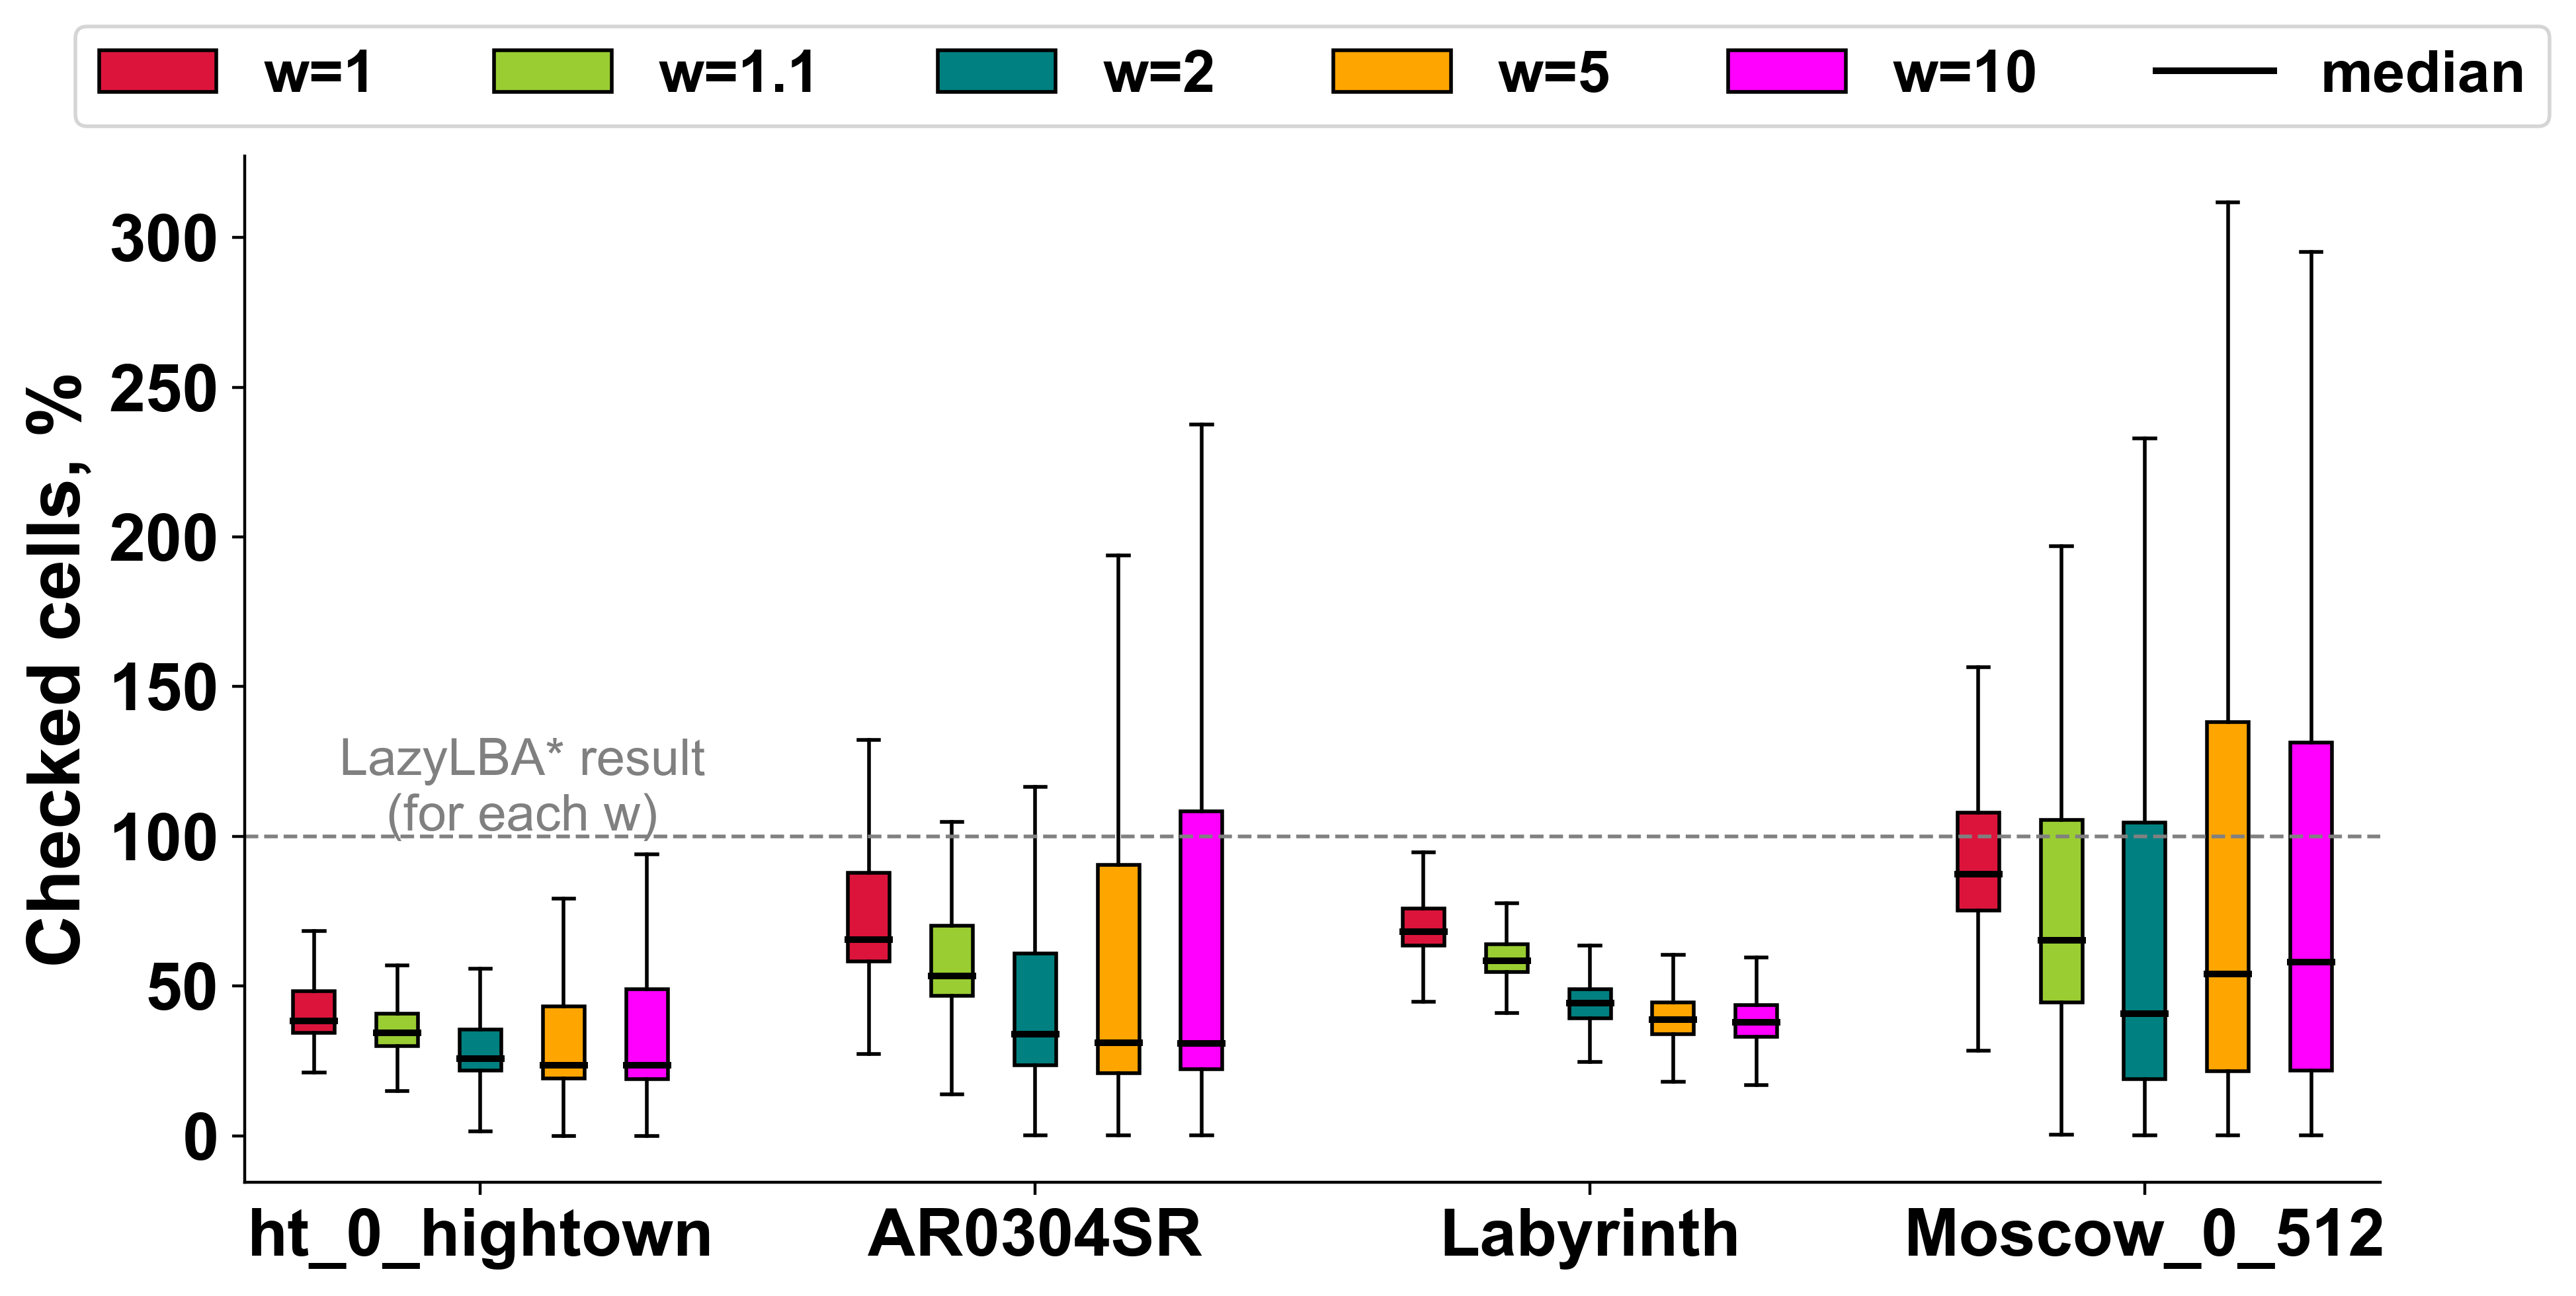

In [23]:
def plot_cells_boxplot(df, maps):
    # Data Configuration
    w_values = [1, 1.1, 2, 5, 10]
    
    # === Prepare Data Structure ===
    # rate_for_w[map_idx][w_idx] -> Array of values
    rate_for_w = []
    
    for i, task_map in enumerate(maps):
        rate_for_w.append([])
        for w in w_values:
            # Filter: Solved by BOTH algorithms
            subset = df[
                (df["Map"] == task_map) & 
                (df["Weight"] == w) & 
                (df["Solved_MeshA*"] == 1) & 
                (df["Solved_LazyLBA*"] == 1)
            ]
            
            # Extract the column we calculated in Preprocessing
            if not subset.empty and "RelCells_MeshA*_vs_Lazy" in subset.columns:
                vals = subset["RelCells_MeshA*_vs_Lazy"].values
                rate_for_w[i].append(vals)
            else:
                rate_for_w[i].append([])

    # === PLOTTING (Strict Legacy Style) ===
    fig, ax = plt.subplots(figsize=(10, 5), dpi=400)
    plt.rcParams['font.family'] = 'sans-serif' 
    plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans'] # Fallback
    
    ax.set_ylabel("Checked cells, %", fontsize=20, fontweight='bold')

    shift = 0.6  # Shift as requested
    index = 4 * np.arange(len(maps))
    
    # 1. Boxplot for w=1
    boxes1 = plt.boxplot((rate_for_w[0][0], rate_for_w[1][0], rate_for_w[2][0], rate_for_w[3][0]), 
           showmeans=False, patch_artist=True, boxprops=dict(facecolor="crimson"),
           widths=shift / 2, positions=index, showfliers=False,
           medianprops=dict(linewidth=1.8, color="black"),
           meanprops=dict(markeredgewidth=0, markerfacecolor="cyan", markersize=8))

    # 2. Boxplot for w=1.1
    boxes2 = plt.boxplot((rate_for_w[0][1], rate_for_w[1][1], rate_for_w[2][1], rate_for_w[3][1]), 
            showmeans=False, patch_artist=True, boxprops=dict(facecolor="yellowgreen"),
            widths=shift / 2, positions=index + 1 * shift, showfliers=False,
            medianprops=dict(linewidth=1.8, color="black"),
            meanprops=dict(markeredgewidth=0, markerfacecolor="cyan", markersize=8))

    # 3. Boxplot for w=2
    boxes3 = plt.boxplot((rate_for_w[0][2], rate_for_w[1][2], rate_for_w[2][2], rate_for_w[3][2]), 
            showmeans=False, patch_artist=True, boxprops=dict(facecolor="teal"),
            widths=shift / 2, positions=index + 2 * shift, showfliers=False,
            medianprops=dict(linewidth=1.8, color="black"),
            meanprops=dict(markeredgewidth=0, markerfacecolor="cyan", markersize=8))

    # 4. Boxplot for w=5
    boxes4 = plt.boxplot((rate_for_w[0][3], rate_for_w[1][3], rate_for_w[2][3], rate_for_w[3][3]), 
            showmeans=False, patch_artist=True, boxprops=dict(facecolor="orange"),
            widths=shift / 2, positions=index + 3 * shift, showfliers=False,
            medianprops=dict(linewidth=1.8, color="black"),
            meanprops=dict(markeredgewidth=0, markerfacecolor="cyan", markersize=8))

    # 5. Boxplot for w=10
    boxes5 = plt.boxplot((rate_for_w[0][4], rate_for_w[1][4], rate_for_w[2][4], rate_for_w[3][4]), 
            showmeans=False, patch_artist=True, boxprops=dict(facecolor="magenta"),
            widths=shift / 2, positions=index + 4 * shift, showfliers=False,
            medianprops=dict(linewidth=1.8, color="black"),
            meanprops=dict(markeredgewidth=0, markerfacecolor="cyan", markersize=8))

    # Legend Construction
    plt.legend([boxes1["boxes"][0], boxes2["boxes"][0], boxes3["boxes"][0], boxes4["boxes"][0], boxes5["boxes"][0],
                boxes1["medians"][0]],
               ["w=1", "w=1.1", "w=2", "w=5", "w=10", "median"],
               bbox_to_anchor=(0.5, 1), labelspacing=1.2, 
               prop={'weight': 'bold', 'size': 16}, loc='lower center', ncol=6)

    # Axis Styling
    plt.xticks(index + 2 * shift, maps)

    for label in ax.get_yticklabels():
        label.set_fontsize(18)
        label.set_fontweight('bold')
    for label in ax.get_xticklabels():
        label.set_fontsize(18)
        label.set_fontweight('bold')

    # General Style
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Reference Line
    ax.axhline(y=100, color='gray', linestyle='--', linewidth=1)
    ax.text(x=1.5, y=102, s="LazyLBA* result\n(for each w)", color='gray', fontsize=14, ha='center')

    plt.tight_layout()
    # plt.savefig("../../images/distribution_checked_cells.png", transparent=False, bbox_inches="tight", facecolor='white')
    plt.show()

# Run
plot_cells_boxplot(df_pivot, TARGET_MAPS)